# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import ipaddress as ip
import pickle
import requests, bs4
from datetime import datetime
import re

from IPython.display import clear_output
pd.options.display.max_columns = 50
%matplotlib inline

# Data

In [2]:
data = pd.DataFrame()
for i in range(1, 8001):
    print(i, '/8000')
    d = pd.read_json('Metrics/'+str(i)+'.json')
    data = pd.concat([data, d], axis=0)
    clear_output(wait=True)

8000 /8000


In [3]:
data = data.reset_index(drop=True)

In [4]:
data.head()

,URL,Label,domainRegistrationLength,Search Traffic,Bounce Rate,Total Sites Linking in,Alexa Rank,Daily Views per Visitor,Daily Time on Site
0,https://nih.gov,0,{'args': ['list index out of range']},72.9%,57.3%,"134,142",#113,3.17,3:57
1,http://www.perfumemart.com/,0,{'args': ['list index out of range']},,50%,26,"#5,193,632",1:43,50.0%
2,http://chronopost-service-enligne.net/56123s/r...,1,{'args': ['list index out of range']},{'args': ['list index out of range']},{'args': ['list index out of range']},{'args': ['list index out of range']},{'args': ['list index out of range']},{'args': ['list index out of range']},{'args': ['list index out of range']}
3,http://wvw.micloudappel.security-updates-myacc...,1,{'args': ['list index out of range']},{'args': ['list index out of range']},{'args': ['list index out of range']},{'args': ['list index out of range']},{'args': ['list index out of range']},{'args': ['list index out of range']},{'args': ['list index out of range']}
4,http://colach8x.beget.tech/likon/mqnger/drwx/P...,1,4,5.1%,45.7%,"7,352","#19,236",5.76,11:37


In [5]:
data.tail()

,URL,Label,domainRegistrationLength,Search Traffic,Bounce Rate,Total Sites Linking in,Alexa Rank,Daily Views per Visitor,Daily Time on Site
7995,http://www.isca-louis.com/,0,{'args': ['list index out of range']},,,{'args': ['list index out of range']},{'args': ['list index out of range']},-,-
7996,https://focus123.cn,0,{'args': ['list index out of range']},0.1%,17.8%,36,"#4,107",4.24,8:13
7997,https://hdfcbank.com,0,30,23.9%,9.8%,"1,460",#338,3.68,5:50
7998,http://www.ecb.co.uk/ecb/rules/,0,21,37.9%,43.3%,806,"#96,328",2.4,2:49
7999,http://social.msdn.microsoft.com/Forums/,0,30,45.8%,58.8%,"399,217",#35,2.54,2:50


In [6]:
data = data.rename(columns = {'domainRegistrationLength': 'Domain Registration Length'}) 

# Cleaning

In [7]:
def drl_cleaner(x):
    try:
        return int(x)
    except:
        return -1
    
data['Domain Registration Length'] = data['Domain Registration Length'].apply(drl_cleaner)

In [8]:
#print(data['Domain Registration Length'].unique())

In [9]:
def st_br_cleaner(x):
    try:
        return float(x[:-1])
    except:
        return -1
    

data['Search Traffic'] = data['Search Traffic'].apply(st_br_cleaner)
data['Bounce Rate'] = data['Bounce Rate'].apply(st_br_cleaner)

In [10]:
#print(data['Search Traffic'].unique())
#print(data['Bounce Rate'].unique())

In [11]:
def tsli_ar_cleaner(x):
    try:
        return int(x.replace('#', '').replace(',', ''))
    except:
        return -1
    
data['Total Sites Linking in'] = data['Total Sites Linking in'].apply(tsli_ar_cleaner)
data['Alexa Rank'] = data['Alexa Rank'].apply(tsli_ar_cleaner)


In [12]:
#print(data['Total Sites Linking in'].unique())
#print(data['Alexa Rank'].unique())

In [13]:
def dvpv_cleaner(x):
    try:
        return float(x)
    except:
        return -1
data['Daily Views per Visitor'] = data['Daily Views per Visitor'].apply(dvpv_cleaner)

In [14]:
#print(data['Daily Views per Visitor'].unique())

In [15]:
def dtos_cleaner(x):
    try:
        if ':' in x:
            a, b = x.split(':')
            return int(a)*60+int(b)
        else:
            return -1
    except:
        return -1
    
data['Daily Time on Site'] = data['Daily Time on Site'].apply(dtos_cleaner)

In [16]:
# print(data['Daily Time on Site'].unique())

# All Features

**01. Long URL to Hide the Suspicious Part**

Phishers can use long URL to hide the doubtful part in the address bar. For example: 
http://federmacedoadv.com.br/3f/aze/ab51e2e319e51502f416dbe46b773a5e/?cmd=_home&amp;dispatch=11004d58f5b74f8dc1e7c2e8dd4105e811004d58f5b74f8dc1e7c2e8dd4105e8@phishing.website.html

In [17]:
length = lambda x : len(x)

In [18]:
data['Length'] = data['URL'].apply(length)

**02. Using the IP Address**
If an IP address is used as an alternative of the domain name in the URL, such as “http://125.98.3.123/fake.html”, users can be sure that someone is trying to steal their personal information. Sometimes, the IP address is even transformed into hexadecimal code as shown in the following link “http://0x58.0xCC.0xCA.0x62/2/paypal.ca/index.html”. 

If the domain part has an IP address -> Phishing

Otherwise -> Legitimate

In [19]:
def isIp(x):
    try:
        if ip.ip_address(x):
            return 1
    except:
        return 0

In [20]:
data['Is IP'] = data['URL'].apply(isIp)

**03. URL’s having “@” Symbol**

Using “@” symbol in the URL leads the browser to ignore everything preceding the “@” symbol and the real address often follows the “@” symbol. 

In [21]:
countAt = lambda x : x.count('@')

In [22]:
data['Count @'] = data['URL'].apply(countAt)

**04. Redirecting using //**

The existence of “//” within the URL path means that the user will be redirected to another website. An example of such URL’s is: “http://www.legitimate.com//http://www.phishing.com”. We examin the location where the “//” appears. We find that if the URL starts with “HTTP”, that means the “//” should appear in the sixth position. However, if the URL employs “HTTPS” then the “//” should appear in seventh position.

In [23]:
countDoubleSlash = lambda x : x.count('//')

In [24]:
data['Count Double Slash'] = data['URL'].apply(countDoubleSlash)

**05. Adding Prefix or Suffix Separated by (-) to the Domain**

The dash symbol is rarely used in legitimate URLs. Phishers tend to add prefixes or suffixes separated by (-) to the domain name so that users feel that they are dealing with a legitimate webpage. For example http://www.Confirme-paypal.com/.

In [25]:
countHyphen = lambda x : x.count('-')

In [26]:
data['Count Hyphen'] = data['URL'].apply(countHyphen)

**06. Sub Domain and Multi Sub Domains**

Let us assume we have the following link: http://www.hud.ac.uk/students/. A domain name might include the country-code top-level domains (ccTLD), which in our example is “uk”. The “ac” part is shorthand for “academic”, the combined “ac.uk” is called a second-level domain (SLD) and “hud” is the actual name of the domain. To produce a rule for extracting this feature, we firstly have to omit the (www.) from the URL which is in fact a sub domain in itself. Then, we have to remove the (ccTLD) if it exists. Finally, we count the remaining dots. If the number of dots is greater than one, then the URL is classified as “Suspicious” since it has one sub domain. However, if the dots are greater than two, it is classified as “Phishing” since it will have multiple sub domains. Otherwise, if the URL has no sub domains, we will assign “Legitimate” to the feature. 


In [27]:
countDots = lambda x: x.count('.')

In [28]:
data['Count Dots'] = data['URL'].apply(countDots)

**07. num of delimeters:**
```    
[';','_','?','=','&']
```

In [29]:
def countDelimeters(x):
    count = 0
    for delim in [';','_','?','=','&']:
        count += x.count(delim)
    return count

In [30]:
data['Count Delimeters'] = data['URL'].apply(countDelimeters)

**08. subdirectory count**

In [31]:
countSubDirectory = lambda x : len(re.findall(r"[\s/\s]", x))

In [32]:
data['Count Subdirectory '] = data['URL'].apply(countSubDirectory)

**09. query count**

In [33]:
def countQueries(x):
    if not x:
        return 0
    else:
        return len(x.split('&'))

In [34]:
data['Count Queries '] = data['URL'].apply(countQueries)

**10. Domain Registration Length**

Based on the fact that a phishing website lives for a short period of time, we believe that trustworthy domains are regularly paid for several years in advance. In our dataset, we find that the longest fraudulent domains have been used for one year only. 

**11. Alexa Global Rank**

**12. Bounce Rate**

The percentage of visitors to a particular website who navigate away from the site after viewing only one page.

**13. Daily Page Views Per Visitor**

**14. Daily Time on Site**

**15. Search Visits**

What percentage of visits to this site come from a search engine?

**16. Total Sites Linking in**

The number of websites in Alexa's crawl of the web that link to a given website.

In [ ]:
to_datetime = lambda x : datetime(int(x[:4]), int(x[5:7]), int(x[8:]))

In [ ]:
def websiteInfo(website):

    website_details = {'URL': [website]}
    try:
        url = 'https://www.whois.com/whois/'+website
        res = requests.get(url)
        if res.status_code == requests.codes.ok:
            ressoup = bs4.BeautifulSoup(res.text, 'lxml')
            elems = ressoup.select('.df-value')
            try:
                regOn = to_datetime(elems[2].getText())
                expOn = to_datetime(elems[3].getText())
                duration = (expOn - regOn).total_seconds()//31556926
                website_details['Domain Registration Length'] = [int(duration)]
            except Exception as e:
                website_details['Domain Registration Length'] = [-1]
        else:
            website_details['Domain Registration Length'] = [-1]
    except Exception as e:
        website_details['Domain Registration Length'] = [-1]
        
    try:
        url = 'https://www.alexa.com/siteinfo/'+website
        res = requests.get(url)
        if res.status_code == requests.codes.ok:
            ressoup = bs4.BeautifulSoup(res.text, 'lxml')

            elems = ressoup.select('.num.purple')
            try:
                website_details['Search Traffic'] = [st_br_cleaner(elems[0].getText())]
            except Exception as e:
                website_details['Search Traffic'] = [-1]
            try:
                website_details['Bounce Rate'] = [st_br_cleaner(elems[1].getText())]
            except Exception as e:
                website_details['Bounce Rate'] = [-1]

            elems = ressoup.select('.big.data')
            try:
                website_details['Total Sites Linking in'] = [tsli_ar_cleaner(elems[1].getText())]
            except Exception as e:
                website_details['Total Sites Linking in'] = [-1]

            elems = ressoup.select('.rankmini-rank')
            try:
                website_details['Alexa Rank'] = [tsli_ar_cleaner(elems[0].getText().strip())]
            except Exception as e:
                website_details['Alexa Rank'] = [-1]

            elems = ressoup.select('.small.data')
            try:
                website_details['Daily Views per Visitor'] = [dvpv_cleaner(elems[1].getText().strip().split()[0])]
            except Exception as e:
                website_details['Daily Views per Visitor'] = [-1]
            try:
                website_details['Daily Time on Site'] = [dtos_cleaner(elems[2].getText().strip().split()[0])]
            except Exception as e:
                website_details['Daily Time on Site'] = [-1]
        else:
            website_details['Search Traffic'] = [-1]
            website_details['Bounce Rate'] = [-1]
            website_details['Total Sites Linking in'] = [-1]
            website_details['Alexa Rank'] = [-1]
            website_details['Daily Views per Visitor'] = [-1]
            website_details['Daily Time on Site'] = [-1]
    except Exception as e:
        website_details['Search Traffic'] = [-1]
        website_details['Bounce Rate'] = [-1]
        website_details['Total Sites Linking in'] = [-1]
        website_details['Alexa Rank'] = [-1]
        website_details['Daily Views per Visitor'] = [-1]
        website_details['Daily Time on Site'] = [-1]
    
    website_details['Length'] = [length(website)]
    website_details['Is IP'] = [isIp(website)]
    website_details['Count @'] = [countAt(website)]
    website_details['Count Double Slash'] = [countDoubleSlash(website)]
    website_details['Count Hyphen'] = [countHyphen(website)]
    website_details['Count Dots'] = [countDots(website)]
    website_details['Count Delimeters'] = [countDelimeters(website)]
    website_details['Count Subdirectory '] = [countSubDirectory(website)]
    website_details['Count Queries '] = [countQueries(website)]
#     print(website_details)
    website_details = pd.DataFrame(website_details)

    return website_details

In [35]:
data.to_csv('featureset.csv', index=False)

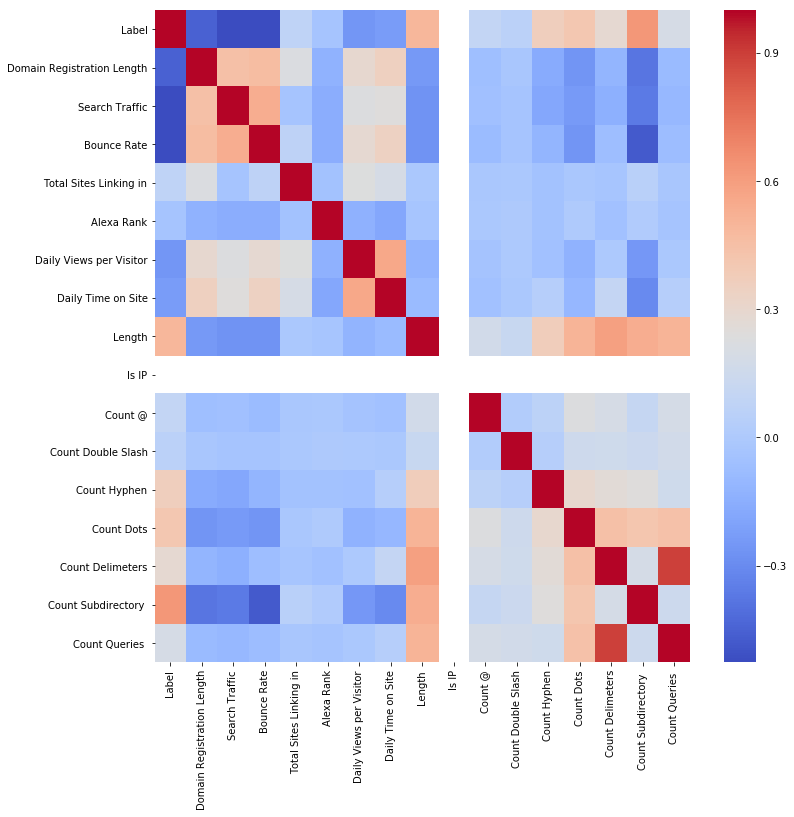

In [36]:
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(data.corr(), cmap='coolwarm', ax=ax)